In [45]:
import pandas as pd
#from utils import randomSplit, Accumulator
#import torch
#from torch import nn
import numpy as np
from sklearn.preprocessing import StandardScaler  # 归一化
from sklearn.model_selection import KFold         # k折交叉验
from sklearn.decomposition import PCA             # pca


#import modules
import kmapper as km
import umap
import sklearn
import sklearn.manifold as manifold

import matplotlib.pyplot as plt
from kmapper.jupyter import display

from sklearn.decomposition import PCA
from sklearn import cluster
import networkx as nx

In [46]:
def numpy_cos(a,b):
    '''求解cos相似度'''
    a = a / np.linalg.norm(a, axis=1).reshape(-1, 1)  # 先renorm，然后相乘就是cos
    b = b / np.linalg.norm(b, axis=1).reshape(-1, 1)
    dot = np.dot(a, b.T) #对应原始相乘dot.sum(axis=1)得到内积
    return dot

class myDataset():
    def __init__(self, renorm=False, pca=False, savehtml=False, **kargs):
        self.player = pd.read_csv('datacleaning/modified_data.csv', header=0, encoding='unicode_escape', delimiter=';')
        #self.player = self.player.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born'], axis=1)
        
        # Squad 和 Season 需要保留
        #self.player = self.player.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born'], axis=1)
        
        if renorm:
            scaler = StandardScaler()  # z score 归一化
            for col in self.player.columns:
                if col in ('Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born', 'Squad'): continue
                self.player[[col]] = scaler.fit_transform(self.player[[col]])
        if pca:
            squad = self.player['Squad']
            season = self.player['Season']
            pos = self.player['Pos']
            values = self.player.drop(['Squad', 'Season'], axis=1).values
            comp_dim = kargs['pca_dim']
            pca = PCA(n_components=comp_dim)   # 15
            values = pca.fit_transform(values)
            # print(sum(pca.explained_variance_ratio_))
            self.player = pd.DataFrame(values)
            self.player['Squad'] = squad
            self.player["Season"] = season
            self.player['Pos'] = pos

        #self.league = pd.read_excel('DLdata/SquadPerformance2021.xlsx', sheet_name='Sheet1')
        #self.league['tier'] = self.league.apply(rank2class, axis=1)
        #self.league = self.league[['Squad', 'Season', 'tier']]       

        #initialize mapper
        mapper = km.KeplerMapper(verbose=0)
        #project data
        self.X_features_numeric = self.player.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born', 'Squad'], axis=1).values  # data array
        self.index2col = list(self.player.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born', 'Squad'], axis=1).columns)  # 将 values 的列id转化为对应的col名称
        projected_X = mapper.fit_transform(self.X_features_numeric, 
                                            projection = [manifold.Isomap(n_components=10, n_jobs=-1),
                                                            umap.UMAP(n_components=2, random_state=1)], scaler=[None])  
        graph2 = mapper.map(projected_X, cover=km.Cover(n_cubes=15),
                clusterer=sklearn.cluster.KMeans(n_clusters=5, random_state=1618033))
        # 根据标签数据y创建对应的color_values
        def create_color_values(y):
            unique_labels = np.unique(y)
            color_values = [str(i + 1) for i in range(unique_labels.shape[0])]
            label_to_color = dict(zip(unique_labels, color_values))
            return np.array([label_to_color[label] for label in y])
        def node_color_func(node):
            labels, counts = np.unique(node, return_counts=True)
            max_count_index = np.argmax(counts)
            ans = create_color_values(labels)
            return ans[max_count_index] 
        pos = np.array(self.player['Pos'])
        
        self.graph = km.adapter.to_nx(graph2)
        colorvaluepos = create_color_values(pos)
        self.closeCenResult = nx.closeness_centrality(self.graph)  # returns dict
        clusters = self.graph.nodes.data()
        colorvalueCloseCen = [[] for i in range(colorvaluepos.shape[0])]
        self.cluster_features = dict()
        for clusterdata in clusters:  # nx nodes view
            # 单个cluster example ('cube0_cluster0', {'membership': [2234, 3793, 5864, 6229, 8196]})
            clus_name = clusterdata[0]
            clus_closeCen = self.closeCenResult[clus_name]
            
            members_l = clusterdata[1]['membership']
            for member in members_l:  # id = dataframe里的index
                colorvalueCloseCen[member].append(clus_closeCen)
            # 生成cluster的特征，先取出对应的menber 的feature，再求平均
            cur_cluster_feature = self.X_features_numeric[np.array(member), :].mean(axis=0)  # shape [1, self.cluster_features_dim]
            self.cluster_features[clus_name] = cur_cluster_feature  #  name -> cluster feature, 可以用来生成其他的表示颜色的变量
        colorvalueCloseCen = np.array([max(l) for l in colorvalueCloseCen])  # 直接对这个结果做标准化和分箱吧
        
        scaler = StandardScaler()
        re = scaler.fit_transform(colorvalueCloseCen.reshape(-1, 1))
        re.sort(axis=0) # 升序 排序
        bins = np.array_split(re, 10)
        seper = np.array([b.min() for b in bins])
        colorvalueCloseCen_2 = np.zeros_like(colorvalueCloseCen)
        for i in range(colorvalueCloseCen.shape[0]):
            colorvalueCloseCen_2[i] = str((seper < re[i]).sum() + 1)  # 不是吧，别太抽象，真要换成str ？？
        

        if savehtml:
            mapper.visualize(graph2, path_html="cluster=5,cubes=15_flare_vacancy.html",
                 title="mapper2", custom_tooltips=pos, color_values=np.c_[colorvaluepos.reshape(-1, 1), colorvalueCloseCen_2.reshape(-1, 1)],
                   node_color_function=('mean', 'max'), color_function_name=('Position', 'CloseCentrality'),
                  include_searchbar=True)
        
        

    def get_members(self, nodes_l, method='ring_opposite', **kargs):
        '''find_ring找到ring的周围节点后，通过该函数获取节点所代表的局部点云，
        method值，k_min 最小的k个，保证每个点都有pair，threshold，选取夹角余弦值小于threshold参数值的东西，一般设置-0.8，不保证都有pair'''
        if isinstance(nodes_l, set):
            nodes_l = list(nodes_l)
        sub_graph = dataset.graph.subgraph(nodes_l)
        member_l = []
        for item in sub_graph.nodes.data():
            member_l += item[1]['membership']
        member_l = list(set(member_l))
        cur_df = self.player.iloc[member_l, :]  # 因为索引是对应的，可以直接按照 X_features的行索引，获取到dataframe 
        #cur_cluster_feature = X_features_numeric[np.array(member_l), :].mean(axis=0)  # shaoe [1, self.cluster_features_dim]
        cur_df = cur_df.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Born', 'Squad'], axis=1)  # 前面drop的除了age都drop了
        centorPoint = cur_df.values.mean(axis=0)
        df_values = cur_df.values
        centor2pointCloudVector = df_values - centorPoint  # 通过向量减法，得到从中心发射到点云的向量的值；计算利用了广播机制
        cosSims = numpy_cos(centor2pointCloudVector, centor2pointCloudVector)
        if method == 'threshold':
            raw_pairs = np.nonzero(cosSims < kargs['threshold'])  # 记录夹角够大的向量的pair, default -0.8
            # np.nonzero return 一个tuple，记录两个index array
            pairset = set()
            for raw, col in zip(*raw_pairs):    
                #if (col, raw) not in pairset:  # 如果对方不在
                pairset.add((raw, col))
        elif method == 'k_min':
            sortedIndex = cosSims.argsort(axis=1)  # 升序排列
            raw_pairs = sortedIndex[:, :kargs['k']]  # default 2
            pairset = set()
            for raw in range(raw_pairs.shape[0]):
                for col in range(raw_pairs.shape[1]):
                    #if (raw_pairs[raw][col], raw) not in pairset:  # 如果对方不在，似乎不需要
                    pairset.add((raw, raw_pairs[raw][col]))   # 添加的是，member的id的pair
        elif method == 'ring_opposite':  # 进一步考虑之后，前面的两种思路都废弃了orzzz
            '''环的对面的节点组成pair，这样的话pair会少一些'''
            pairset = set()  # 目前决定是cluster
            for node in nodes_l:
                path_dic = nx.shortest_path(sub_graph, source=node)
                path_dic = sorted([(key, len(n_l)) for key, n_l in path_dic.items()], key=lambda x: x[1], reverse=True)
                path_dic = [k for k, l in path_dic if l == path_dic[0][1] or l >= 5] # 取出最长的那些路径对应的节点
                for target in path_dic:
                    pairset.add((node, target))
            # 接下来分析每一对cluster pair内的节点在在各个特征维度的差值，的最小值（作为环的内界），此外为了robustness，最小值可以替换为p25分位点
            cluster_pair_differs_l = []
            for node, target in list(pairset):
                member_l1 = sub_graph.nodes[node]['membership']
                member_l2 = sub_graph.nodes[target]['membership']  # 取出source和target的节点中的所有member
                differ_l = []
                for m1 in member_l1: # member's global raw id
                    for m2 in member_l2:
                        differ_l.append(self.X_features_numeric[m1] - self.X_features_numeric[m2])
                diffdata = np.abs(np.stack(differ_l, axis=0))
                percentile = 0.25  # 取p25分位点，如果取最小值则是 0
                cur_cluster_pair_features_differ = np.percentile(diffdata, percentile, axis=0)  # axis意味着在行维度，也即样本之间取percentile，返回的shape 为 [135,]
                cluster_pair_differs_l.append(cur_cluster_pair_features_differ)
            cluster_pair_differs_l = np.stack(cluster_pair_differs_l, axis=0)
        # 上述步骤得到了，在拓扑空间内，被认为相对的节点pairs，接下来计算差值
        else:
            raise ValueError(f'method {method} is unsupported.')
        #differ_l = [] # list of numpy array
        #for pair in list(pairset): # pairset里面的member的值，是全局的player id，不能用cur_df中取出的values
        #    differ_l.append(self.X_features_numeric[pair[0]] - self.X_features_numeric[pair[1]])  # 乐，昨晚写的时候真的是神志不清…… 明显错了
                        
        

        

        # 需要的都return吧
        return member_l, cur_df, cluster_pair_differs_l


    def find_ring(self, node1, node2, node3=None):
        '''给定3个点，通过寻找两到三条最短路径的思路，寻找到环上的节点，
            最短的两条不重合，或者不相邻的路径，构成一个需要的环'''
        '''使用networkx的shortest_simple_paths函数'''
        path_l = []
        last_len = 100000
        if node3 is None: flag = 1
        else: flag = 0
        for path in nx.shortest_simple_paths(self.graph, node1, node2):
            path_l.append(path)
            if len(path) < last_len: last_len = len(path)
            if len(path) > last_len + flag: break  # 这样的话多一个兼容一下只提供两个节点的情况，试试效果啦
        if node3 is not None:
            last_len = 100000
            for path in nx.shortest_simple_paths(self.graph, node1, node3):
                path_l.append(path)
                if len(path) < last_len: last_len = len(path)
                if len(path) > last_len: break
            last_len = 100000
            for path in nx.shortest_simple_paths(self.graph, node2, node3):
                path_l.append(path)
                if len(path) < last_len: last_len = len(path)
                if len(path) > last_len: break
        # return path_l
        return set([node for path in path_l for node in path])

    def draw_subGraph(self, nodes_l):
        '''将函数find_ring得到的结果可视化成一个子图'''
        if isinstance(nodes_l, set):
            nodes_l = list(nodes_l)
        sub_graph = dataset.graph.subgraph(nodes_l)
        nx.draw(sub_graph)


dataset = myDataset(renorm=1)


C:\Users\xxxx\AppData\Roaming\Python\Python39\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [47]:
node1 = 'cube63_cluster4'
node2 = 'cube54_cluster1'
node3 = 'cube53_cluster2'
res = dataset.find_ring(node1=node1, node2=node2, node3=None)
print(res)
sub_graph = dataset.graph.subgraph(list(res))
member_l, cur_df, cluster_pair_differs_l = dataset.get_members(list(res), method='ring_opposite')

{'cube64_cluster1', 'cube64_cluster0', 'cube52_cluster0', 'cube63_cluster3', 'cube53_cluster2', 'cube43_cluster1', 'cube42_cluster4', 'cube42_cluster0', 'cube52_cluster3', 'cube53_cluster0', 'cube41_cluster1', 'cube63_cluster4', 'cube52_cluster1', 'cube42_cluster1', 'cube63_cluster0', 'cube65_cluster1', 'cube41_cluster2', 'cube42_cluster3', 'cube54_cluster1', 'cube64_cluster2', 'cube53_cluster1', 'cube43_cluster3', 'cube41_cluster4', 'cube54_cluster4', 'cube64_cluster4', 'cube53_cluster4', 'cube52_cluster4', 'cube41_cluster3', 'cube64_cluster3', 'cube53_cluster3'}


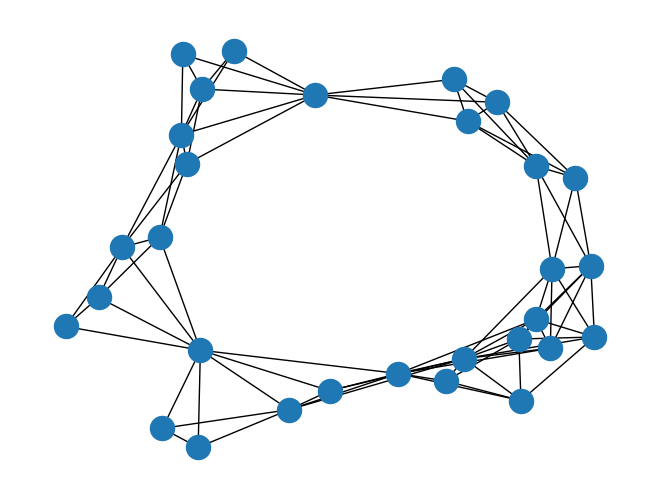

In [48]:
dataset.draw_subGraph(list(res))

[ 12  13  42  46 108 109 110 111 112]


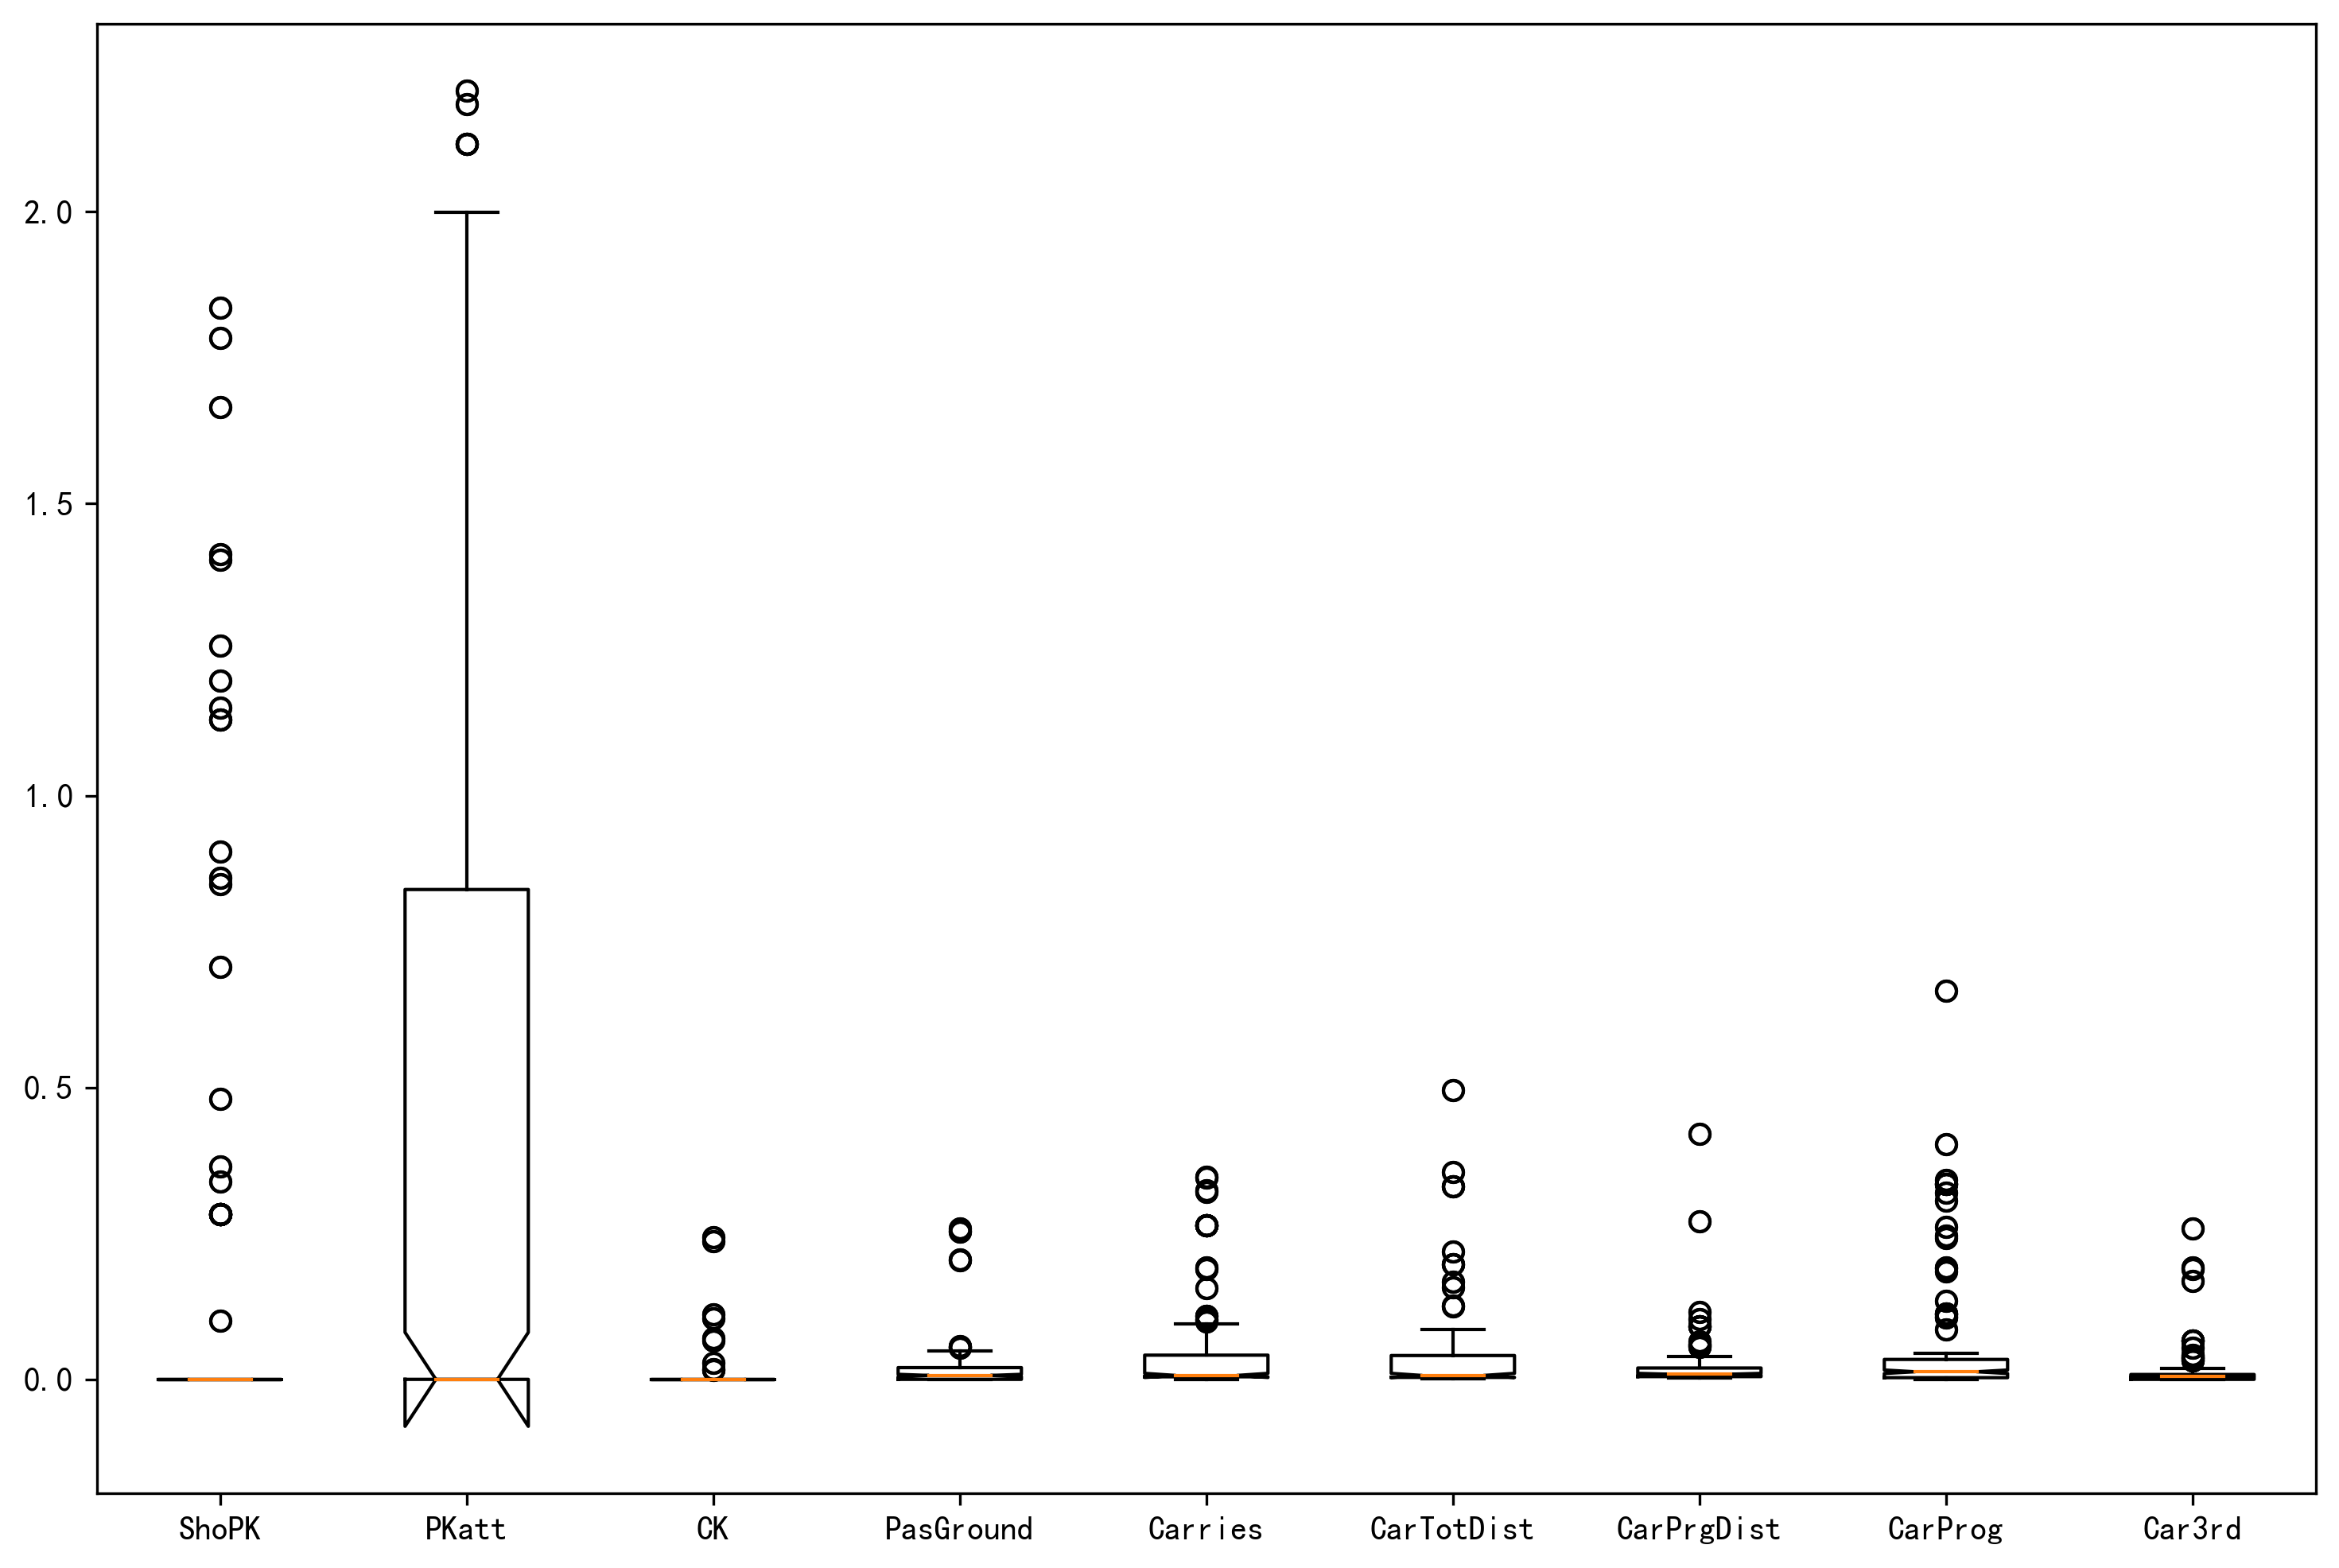

In [61]:
idx = np.nonzero(cluster_pair_differs_l.max(axis=0) > 0.2)[0]  # 选出大于0.02的特征，得到的global idx
print(idx)
values = cluster_pair_differs_l[:, idx]   # 选出这些特征的原始数据，它们被认为是在这个空洞中显著存在差异的特征
# 想用中文必须进行设置RC参数
plt.rcParams['font.sans-serif'] = 'SimHei'
# 设置RC参数字体，让其支持中文
plt.rcParams['axes.unicode_minus'] = False
# 加载数据
# 创建画布
plt.figure(dpi=300,figsize=(12,8))
labels = [dataset.index2col[i] for i in idx]
# notch --缺口 meanline --均值线
plt.boxplot(values, meanline=True, notch=True, labels=labels)  # x size [raw, features]
plt.show()


In [58]:
print(values.shape)
cors = np.corrcoef(values.T) # 要求输入的shape [nfeatures, nsamples]
print(cors.shape)
#print(cors)
significant_correlate = []
for raw in np.argwhere(cors < -0.2):
    if raw[0] > raw[1]:
        significant_correlate.append((raw, cors[raw[0]][raw[1]]))

print(significant_correlate)
for raw, pearson in significant_correlate:
    print(dataset.index2col[idx[raw[0]]], dataset.index2col[idx[raw[1]]], round(pearson, 3))

# 我似乎关联挖掘的方法有错误，这种方法找到的高度相关的两个变量，往往只是含义相近，而不是vacancy
# 似乎是负相关？此消彼长？？orzzz 数学直觉一点都不剩了，我做的这些东西除了直觉还剩什么吗？没有力
# xs，make sense了，但是meaningless

(268, 3)
(3, 3)
[]


In [73]:
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
#pca = PCA(n_components=3)
#values = pca.fit_transform(values)
origin_values = dataset.X_features_numeric[member_l, :][:, np.array([12,  13, 111])]
plot_point_cloud(origin_values)


In [71]:
origin_values.shape

(3, 135)

In [51]:
a, df = dataset.get_members(res)
# 先求出点云的最中心位置
# 后面一步，我的想法是，不是求最小化cos值的，而是计算让cos值小于一定范围的
(df.values - df.values.mean(axis=0)).shape


ValueError: too many values to unpack (expected 2)

In [ ]:
cen = np.array([v for k, v in dataset.closeCenResult.items()])
print(cen.mean())
print(cen.std())
scaler = StandardScaler()
re = scaler.fit_transform(cen.reshape(-1, 1))
count, seper = np.histogram(re, bins=10)
print(seper)
print(re[0])
print((seper < re[0]).sum()+1)
re.sort(axis=0)
bins = np.array_split(re, 10)
bin_counts = np.array([b.min() for b in bins])
print(bin_counts)  # 每个区间的个数
#print(bins)


0.063851029551173
0.024151818321576722
[-2.54250181e+00 -2.11865090e+00 -1.69479999e+00 -1.27094908e+00
 -8.47098164e-01 -4.23247253e-01  6.03658085e-04  4.24454569e-01
  8.48305480e-01  1.27215639e+00  1.69600730e+00]
[-1.96884187]
3
[-2.54250181 -1.75916604 -0.4966726  -0.28493456 -0.01881338  0.12057657
  0.39220652  0.56767407  0.80134009  1.1952677 ]


0.063851029551173
0.024151818321576722


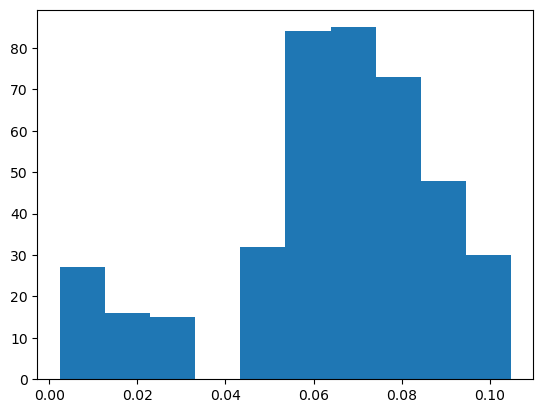

In [ ]:
cen = np.array([v for k, v in dataset.closeCenResult.items()])
print(cen.mean())
print(cen.std())
plt.hist(cen)
plt.show()

3.4660621256590254e-16
1.0


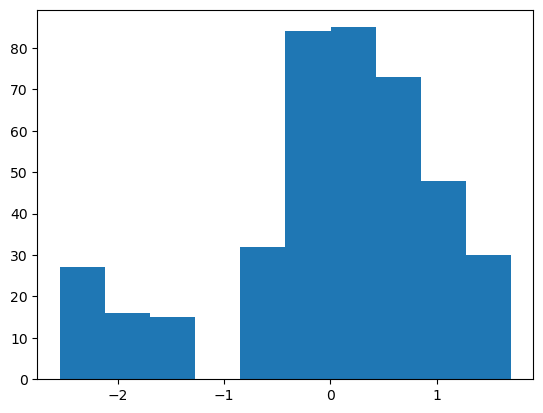

In [ ]:
scaler = StandardScaler()
re = scaler.fit_transform(cen.reshape(-1, 1))
print(re.mean())
print(re.std())
plt.hist(re)
plt.show()